In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [2]:
from replay.preprocessing.filters import MinCountFilter
from replay.splitters import TimeSplitter, LastNSplitter, ColdUserRandomSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/tst/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [4]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/gowalla/interactions.parquet")

In [5]:
interactions

,userId,checkInTime,locationId,relevant
0,0,1.287533e+09,22847,1
1,0,1.287440e+09,420315,1
2,0,1.287359e+09,316637,1
3,0,1.287344e+09,16516,1
4,0,1.287255e+09,5535878,1
...,...,...,...,...
6442887,196578,1.276263e+09,906885,1
6442888,196578,1.276263e+09,965121,1
6442889,196578,1.276263e+09,1174322,1
6442890,196585,1.286572e+09,471724,1


In [9]:
print(f"Number of unique users: {interactions.userId.nunique()}")
print(f"Number of unique items: {interactions.locationId.nunique()}")

Number of unique users: 107092
Number of unique items: 1280969


In [14]:
pd.to_datetime(interactions['checkInTime'], unit='s').describe()

/tmp/ipykernel_1794540/3678505675.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(interactions['checkInTime'], unit='s').describe()


count                 6442892
unique                5561957
top       2010-10-08 17:50:58
freq                        8
first     2009-02-04 05:17:38
last      2010-10-23 05:22:06
Name: checkInTime, dtype: object

In [15]:
pd.to_datetime(interactions['checkInTime'], unit='s')

0         2010-10-19 23:55:27
1         2010-10-18 22:17:43
2         2010-10-17 23:42:03
3         2010-10-17 19:26:05
4         2010-10-16 18:50:42
                  ...        
6442887   2010-06-11 13:32:26
6442888   2010-06-11 13:26:45
6442889   2010-06-11 13:26:34
6442890   2010-10-08 21:01:49
6442891   2010-10-07 17:39:18
Name: checkInTime, Length: 6442892, dtype: datetime64[ns]

In [16]:
interactions.head()

,userId,checkInTime,locationId,relevant
0,0,1.287533e+09,22847,1
1,0,1.287440e+09,420315,1
2,0,1.287359e+09,316637,1
3,0,1.287344e+09,16516,1
4,0,1.287255e+09,5535878,1


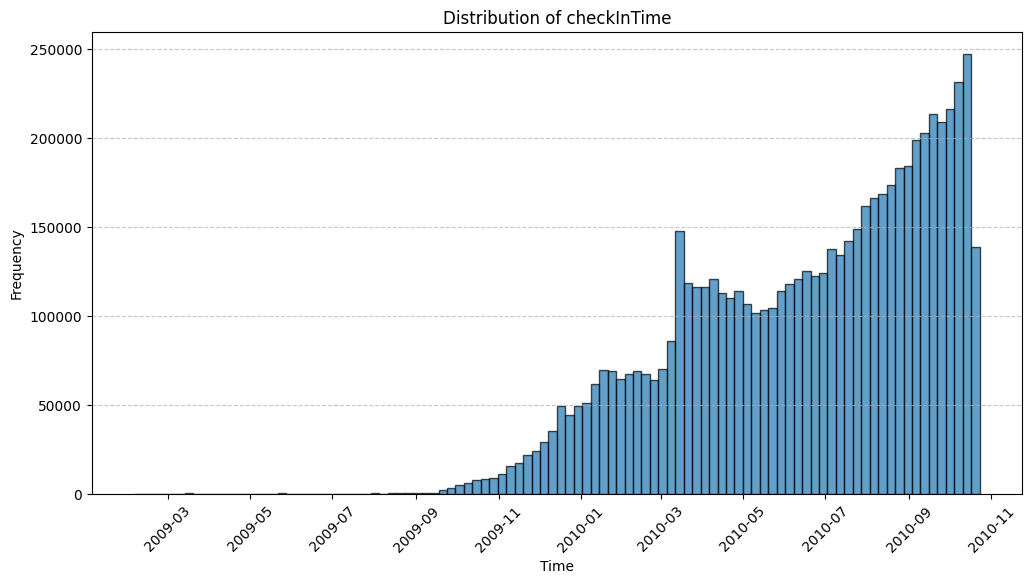

In [17]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 's', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions, timestamp_col='checkInTime')


In [19]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("userId").size().min()
        item_min = data.groupby("locationId").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="locationId",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="userId",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 2


In [21]:
print(interactions.shape)
print(pd.to_datetime(interactions.checkInTime.min(), unit='s'))
print(pd.to_datetime(interactions.checkInTime.max(), unit='s'))
density = (len(interactions) / (interactions['userId'].nunique() * interactions['userId'].nunique())) * 100
print(f"Interaction Density: {density:.3f}%")
mean_seq_len = interactions.groupby('locationId').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.3f}")

(4660733, 4)
2009-02-04 05:17:38
2010-10-23 05:22:06
Interaction Density: 0.065%
Mean Sequence Length: 15.085


In [22]:
print(f"Number of unique users: {interactions.userId.nunique()}")
print(f"Number of unique items: {interactions.locationId.nunique()}")

Number of unique users: 84766
Number of unique items: 308962


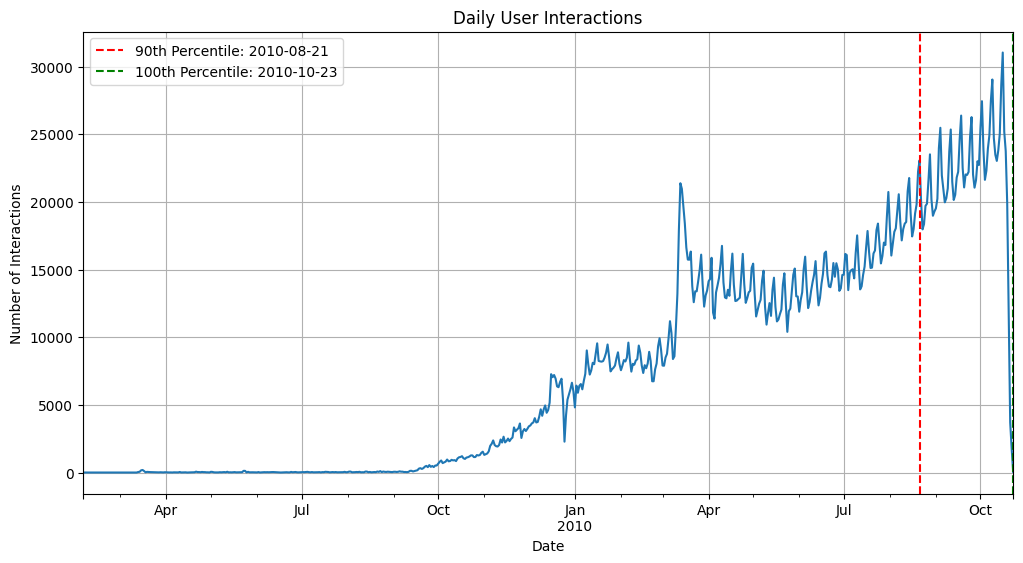

In [23]:
temp_interactions = interactions.copy()
temp_interactions['checkInTime'] = pd.to_datetime(temp_interactions['checkInTime'], unit='s')
daily_interactions = temp_interactions.resample('D', on='checkInTime').size()
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    global_splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=False,
        drop_cold_items=True,
        item_column='locationId',
        query_column='userId',
        timestamp_column="checkInTime",
    )
    val_splitter = ColdUserRandomSplitter(
        test_size=0.1,
        drop_cold_items=True,
        query_column='userId',
        item_column='locationId',
        seed=42,
    )
    loo_splitter = LastNSplitter(
        N=1,
        drop_cold_users=True,
        drop_cold_items=False,
        divide_column='userId',
        query_column='userId',
        strategy="interactions",
        timestamp_column="checkInTime",
    )

    train, raw_test = global_splitter.split(interactions)
    train_events, val = val_splitter.split(train)
    test_users = set(raw_test['userId']) - set(val['userId'])
    test_events, test_gt = loo_splitter.split(
        interactions[
            (interactions['userId'].isin(test_users))
            & interactions['locationId'].isin(train_events['locationId'].unique())
        ]
    )
    validation_events, validation_gt = loo_splitter.split(val)
    test_gt = test_gt[test_gt['locationId'].isin(train_events['locationId'])]
    test_gt_correct = test_gt[test_gt['userId'].isin(test_events['userId'])]
    test_gt = test_gt[test_gt['userId'].isin(train_events['userId'])]
    print(
            f"Distribution of seq_len in validation:\n{validation_events.groupby('userId')['locationId'].agg('count').describe()}."
        )
    print(
        f"Distribution of seq_len in validation gt:\n{validation_gt.groupby('userId')['locationId'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_events.groupby('userId')['locationId'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt correct:\n{test_gt_correct.groupby('userId')['locationId'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt:\n{test_gt.groupby('userId')['locationId'].agg('count').describe()}."
    )

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    7890.000000
mean       48.511407
std       105.595160
min         1.000000
25%         7.000000
50%        18.000000
75%        45.000000
max      1532.000000
Name: locationId, dtype: float64.
Distribution of seq_len in validation gt:
count    7890.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: locationId, dtype: float64.
Distribution of seq_len in test:
count    36692.000000
mean        77.977570
std        142.588837
min          1.000000
25%         14.000000
50%         33.000000
75%         82.000000
max       1981.000000
Name: locationId, dtype: float64.
Distribution of seq_len in test gt correct:
count    36692.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: locationId, dtype: float64.
Distribution of seq_len in test gt:
count    32637.0
mean         1.0
std          0.0
min        